In [65]:
from collections import Counter, defaultdict

import Levenshtein
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Align import substitution_matrices
from tqdm import tqdm, trange

In [2]:
extended_iupac_protein_alphabet = set('ACDEFGHIKLMNPQRSTVWYBXZJUO')

In [3]:
def clean_data(data: pd.DataFrame, tcr_col: str, pep_col: str) -> pd.DataFrame:
    print(f'Raw data size = {len(data):,}')

    data = data[data[tcr_col].notna() & data[pep_col].notna()]
    data = data.drop_duplicates([tcr_col, pep_col])
    data = data[[all(aa in extended_iupac_protein_alphabet for aa in peptide) for peptide in data[pep_col]]]

    print(f'Clean data size = {len(data):,}')

    return data

In [18]:
ALL_METADATA = {
    'vdjdb': {
        'path': '../../data/databases/vdjdb.tsv',
        'sep': '\t',
        'tcr_col': 'CDR3',
        'pep_col': 'Epitope',
        'gene_col': 'Gene'
    },
    'mcpas': {
        'path': '../../data/databases/McPAS-TCR.csv',
        'sep': ',',
        'tcr_col': 'CDR3.beta.aa',
        'pep_col': 'Epitope.peptide'
    },
    'iedb_positive': {
        'path': '../../data/databases/iedb_positive.csv',
        'sep': ',',
        'tcr_col': 'Chain 2 CDR3 Calculated',
        'pep_col': 'Description'
    }
}

In [202]:
datasets = [
    'vdjdb',
    'mcpas',
    'iedb_positive'
]

In [208]:
tcr_peptide_pairs = set()
for dataset in datasets:
    print(dataset)
    metadata = ALL_METADATA[dataset]

    data = pd.read_csv(metadata['path'], sep=metadata['sep'])

    if 'gene_col' in metadata:
        data = data[data[metadata['gene_col']] == 'TRB']

    data = clean_data(data, tcr_col=metadata['tcr_col'], pep_col=metadata['pep_col'])

    tcr_peptide_pairs |= set(zip(data[metadata['tcr_col']], data[metadata['pep_col']]))
    print()

tcr_peptide_pairs = sorted(tcr_peptide_pairs)

vdjdb
Raw data size = 52,262
Clean data size = 42,607

mcpas
Raw data size = 39,664
Clean data size = 12,331

iedb_positive
Raw data size = 203,890
Clean data size = 122,155



In [209]:
peptides = sorted({tcr_peptide[1] for tcr_peptide in tcr_peptide_pairs})
print(f'Num unique peptides = {len(peptides):,}')

Num unique peptides = 2,117


In [210]:
tcrs = sorted({tcr_peptide[0] for tcr_peptide in tcr_peptide_pairs})
print(f'Num unique TCRs = {len(tcrs):,}')

Num unique TCRs = 163,216


In [211]:
print(f'Num unique TCR-peptide pairs = {len(tcr_peptide_pairs):,}')

Num unique TCR-peptide pairs = 172,682


In [212]:
peptide_to_tcr = defaultdict(set)
tcr_to_peptide = defaultdict(set)

for tcr, peptide in tcr_peptide_pairs:
    peptide_to_tcr[peptide].add(tcr)
    tcr_to_peptide[tcr].add(peptide)

In [213]:
tcr_counts_per_peptide = Counter([len(tcrs) for tcrs in peptide_to_tcr.values()])
print(f'Num peptides with > 1 TCRs: {len(peptides) - tcr_counts_per_peptide[1]:,}\n')
for tcr_count in sorted(tcr_counts_per_peptide)[:5]:
    print(f'Num peptides with {tcr_count:,} TCRs: {tcr_counts_per_peptide[tcr_count]:,}')
print('...')

Num peptides with > 1 TCRs: 1,246

Num peptides with 1 TCRs: 871
Num peptides with 2 TCRs: 299
Num peptides with 3 TCRs: 168
Num peptides with 4 TCRs: 84
Num peptides with 5 TCRs: 80
...


In [214]:
peptide_counts_per_tcr = Counter([len(peptides) for peptides in tcr_to_peptide.values()])
print(f'Num TCRs with > 1 peptides: {len(tcrs) - peptide_counts_per_tcr[1]:,}\n')
for peptide_count in sorted(peptide_counts_per_tcr)[:5]:
    print(f'Num TCRs with {peptide_count:,} peptides: {peptide_counts_per_tcr[peptide_count]:,}')
print('...')

Num TCRs with > 1 peptides: 6,585

Num TCRs with 1 peptides: 156,631
Num TCRs with 2 peptides: 5,142
Num TCRs with 3 peptides: 894
Num TCRs with 4 peptides: 287
Num TCRs with 5 peptides: 102
...


In [221]:
unique_peptide_pairs = sorted({tuple(sorted(peptides)) for peptides in tcr_to_peptide.values() if len(peptides) == 2})
print(f'Number of unique peptide pairs shared across a TCR = {len(unique_peptide_pairs):,}')

Number of unique peptide pairs shared across a TCR = 1,623


In [216]:
scoring = substitution_matrices.load("BLOSUM62")
gap_open = -5.0
gap_extend = -0.5

In [217]:
peptide_pair_scores = []
peptide_pair_dists = []
for pep_1, pep_2 in tqdm(unique_peptide_pairs):
    peptide_pair_scores.append(pairwise2.align.globalds(pep_1, pep_2, scoring, gap_open, gap_extend, score_only=True))
    peptide_pair_dists.append(Levenshtein.distance(pep_1, pep_2))
#     if  5 <= peptide_pair_dists[-1] < 11:
#         print(pep_1, pep_2)

100%|██████████████████████████████████████| 1623/1623 [00:11<00:00, 147.53it/s]


Text(0, 0.5, 'Count')

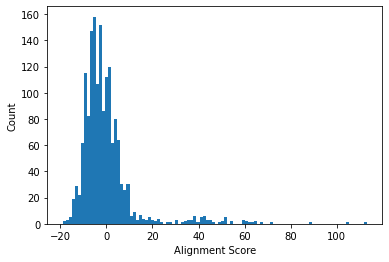

In [218]:
plt.hist(peptide_pair_scores, bins=100)
plt.xlabel('Alignment Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

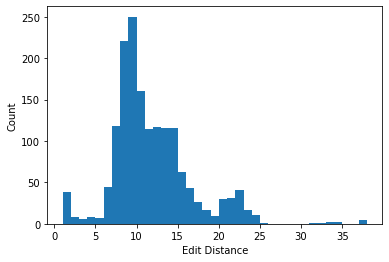

In [219]:
plt.hist(peptide_pair_dists, bins=max(peptide_pair_dists) - min(peptide_pair_dists))
plt.xlabel('Edit Distance')
plt.ylabel('Count')

Text(0, 0.5, 'Aligment Score')

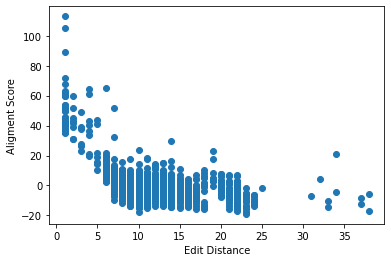

In [220]:
plt.scatter(peptide_pair_dists, peptide_pair_scores)
plt.xlabel('Edit Distance')
plt.ylabel('Aligment Score')

In [187]:
num_peptides = 100  # len(peptides)
scores = np.zeros((num_peptides, num_peptides))

for i in trange(num_peptides):
    for j in range(i + 1, num_peptides):
        scores[i, j] = pairwise2.align.globalds(peptides[i], peptides[j], scoring, gap_open, gap_extend, score_only=True)

  9%|███▊                                       | 9/100 [00:05<00:53,  1.69it/s]


SystemError: <built-in function _make_score_matrix_fast> returned a result with an error set

In [236]:
scores_flat = [scores[i, j] for i in range(num_peptides) for j in range(i + 1, num_peptides)]

(array([  1.,   1.,   3.,   1.,   7.,  10.,  14.,  15.,  30.,  53.,  59.,
         98., 116., 148., 198., 271., 296., 329., 349., 303., 465., 302.,
        314., 280., 235., 191., 167., 115., 106.,  85.,  70.,  52.,  34.,
         29.,  24.,  17.,  19.,   6.,   8.,   8.,  15.,   2.,   2.,   0.,
          2.,   4.,   0.,   0.,   0.,   2.,   2.,   8.,   5.,  10.,   5.,
          3.,   8.,   7.,   4.,   6.,   1.,   6.,   6.,   1.,   1.,   2.,
          2.,   1.,   2.,   0.,   1.,   1.,   3.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-22.   , -20.975, -19.95 , -18.925, -17.9  , -16.875, -15.85 ,
        -14.825, -13.8  , -12.775, -11.75 , -10.725,  -9.7  ,  -8.675,
         -7.65 ,  -6.625,  -5.6  ,  -4.575,  -3.55 ,  -2.525,  -1.5  ,
         -0.475,   0.55 ,   1.575,   2.6  ,   3.625,   4.65 ,   5.675,
          6.7  ,   7.725,   8.75 ,

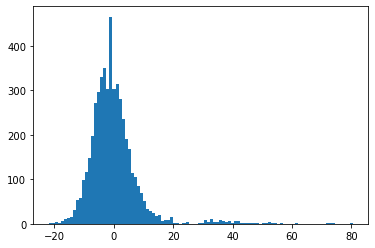

In [237]:
_ = plt.hist(scores_flat, bins=100)

In [238]:
mean = np.mean(scores_flat)
std = np.std(scores_flat)
print(f'Scores = {mean:.2f} +/- {std:.2f}')

threshold = mean + 3 * std
print(f'Threshold = mean + 3 * std = {threshold}')

I, J = np.where(scores > threshold)

Scores = -0.18 +/- 8.39
Threshold = mean + 3 * std = 24.98550051381914


In [239]:
for i, j in zip(I, J):
    print(peptides[i], peptides[j])

AAGIGILTV ALAGIGILTV
AAGIGILTV ALGIGILTV
AAQNVHFWKALNQL AAQRIHFFKNLSLL
AAQRIHFFKNLSLL AENPVVHFFKNIATPR
AAQRIHFFKNLSLL ANPVVHFFKNIVTPR
AAQRIHFFKNLSLL ARSVFHFFRGTALL
ACDPHSGHFV ALDPHSGHFV
ADGLAYFRSSFKGG ADPADPLAFFSSAIKGGGGSLV
ADGLAYFRSSFKGG ANGVAFFLTPFKKA
ADLIAYFKAATKF ADLIAYLKQASK
ADLIAYFKAATKF ADLIAYLKQATAK
ADLIAYFKAATKF ADLIAYLKQATK
ADLIAYFKAATKF ADLIAYLKQATKK
ADLIAYFKAATKF ADLIAYPKAATKF
ADLIAYFKAATKF ANERADLIAYLEQATK
ADLIAYFKAATKF ANERADLIAYLKQATK
ADLIAYFKAATKF ANERADLIAYLRQATK
ADLIAYLKQASK ADLIAYLKQATAK
ADLIAYLKQASK ADLIAYLKQATK
ADLIAYLKQASK ADLIAYLKQATKK
ADLIAYLKQASK ADLIAYPKAATKF
ADLIAYLKQASK ANERADLIAYLEQATK
ADLIAYLKQASK ANERADLIAYLKQATK
ADLIAYLKQASK ANERADLIAYLRQATK
ADLIAYLKQATAK ADLIAYLKQATK
ADLIAYLKQATAK ADLIAYLKQATKK
ADLIAYLKQATAK ADLIAYPKAATKF
ADLIAYLKQATAK ANERADLIAYLEQATK
ADLIAYLKQATAK ANERADLIAYLKQATK
ADLIAYLKQATAK ANERADLIAYLRQATK
ADLIAYLKQATK ADLIAYLKQATKK
ADLIAYLKQATK ADLIAYPKAATKF
ADLIAYLKQATK ANERADLIAYLEQATK
ADLIAYLKQATK ANERADLIAYLKQATK
ADLIAYLKQATK ANERADLIAYLRQAT

In [240]:
graph = nx.Graph()
graph.add_nodes_from(peptides[:num_peptides])
for i, j in zip(I, J):
    graph.add_edge(peptides[i], peptides[j])

In [241]:
components = [sorted(component) for component in sorted(nx.connected_components(graph), key=len, reverse=True) if len(component) > 1]
connected_peptides = [peptide for component in components for peptide in component]
connnected_graph = graph.subgraph(connected_peptides)

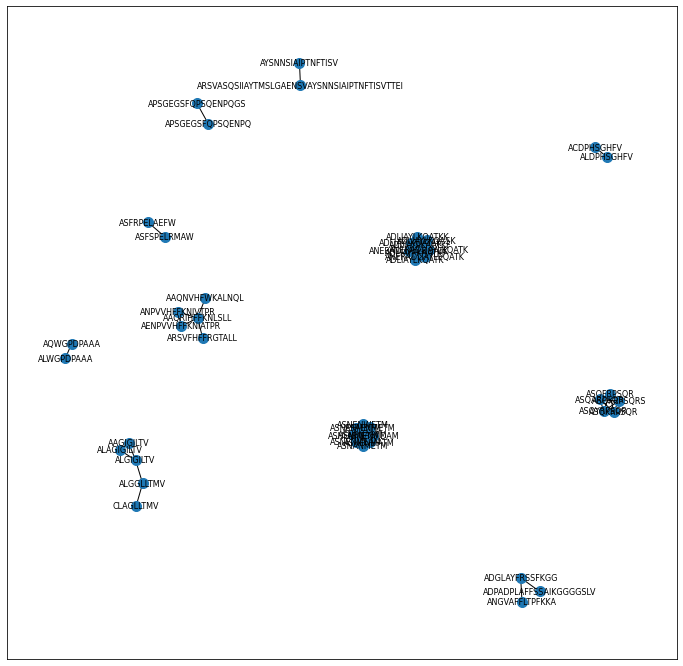

In [242]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(connnected_graph, node_size=100, font_size=8)

In [244]:
for index, component in enumerate(components):
    tcr_to_count = defaultdict(int)

    for peptide in component:
        for tcr in peptide_to_tcr[peptide]:
            tcr_to_count[tcr] += 1

    num_shared_tcrs = sum(count > 1 for count in tcr_to_count.values())

    if num_shared_tcrs > 0:
        print(f'Component {index}\n')
        print(f'Num peptides = {len(component):,}')
        print(f'Num TCRs = {len(tcr_to_count):,}')
        print(f'Num shared TCRs = {num_shared_tcrs:,}\n')

        for tcr, count in tcr_to_count.items():
            if count > 1:
                print(f'{tcr}: {count:,}')

        print('\n' + '-' * 20 + '\n')

Component 0

Num peptides = 9
Num TCRs = 2
Num shared TCRs = 2

ASSLNWSQDTQY: 7
ASSLNNANSDYT: 4

--------------------

Component 1

Num peptides = 9
Num TCRs = 3
Num shared TCRs = 2

ASSRDLGRDTQY: 7
ASSSRTGGHAEQF: 3

--------------------

Component 2

Num peptides = 5
Num TCRs = 7
Num shared TCRs = 2

ASSHAGLGVEQY: 2
ASSYVSQNNEQF: 2

--------------------

Component 3

Num peptides = 5
Num TCRs = 2
Num shared TCRs = 2

SARDLTSGANNEQF: 3
ATSALGDTQY: 2

--------------------

Component 4

Num peptides = 5
Num TCRs = 2
Num shared TCRs = 2

ASGDAGGGYEQY: 4
ASGDASGAETLY: 2

--------------------

Component 5

Num peptides = 3
Num TCRs = 2
Num shared TCRs = 1

ASSLNNANSDYT: 2

--------------------

Component 6

Num peptides = 2
Num TCRs = 1
Num shared TCRs = 1

ASSVVAGFNEQF: 2

--------------------

Component 7

Num peptides = 2
Num TCRs = 1
Num shared TCRs = 1

ASSLWEKLAKNIQY: 2

--------------------

Component 10

Num peptides = 2
Num TCRs = 1
Num shared TCRs = 1

ASTGSYGYT: 2

--------------

In [333]:
metadata = ALL_METADATA['iedb_positive']
neg = pd.read_csv('../../data/iedb_negative.csv', sep=metadata['sep'])
# neg = clean_data(neg, tcr_col=metadata['tcr_col'], pep_col=metadata['pep_col'])
neg = neg[[all(aa in extended_iupac_protein_alphabet for aa in peptide) for peptide in neg['Description']]]
neg = neg[neg['Chain 2 CDR3 Calculated'].notna() | neg['Chain 2 CDR3 Curated'].notna()]
neg.head()

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,MHC Allele Names,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
0,8493,58,1004580,16878,FLRGRAYGL,nuclear antigen EBNA-3,Human herpesvirus 4 (Epstein Barr virus),T cell,"1814845, 1814846, 1814847",HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
1,8493,58,1004580,144889,FLRGRFYGL,NaN,NaN,T cell,1831737,HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
2,8493,58,1017865,142137,EEYLQAFTY,ATP-binding cassette sub-family D member 3,Homo sapiens (human),T cell,1778798,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
3,8493,58,1017865,16878,FLRGRAYGL,nuclear antigen EBNA-3,Human herpesvirus 4 (Epstein Barr virus),T cell,1778796,HLA-B*08:01,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
4,8493,58,1017865,156273,EEYLKAWTF,NaN,NaN,T cell,1779482,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0


In [345]:
print(f'Num unique peptides = {neg["Description"].nunique():,}')
print(f'Num unique TCRs = {len(set(neg["Chain 2 CDR3 Calculated"]) | set(neg["Chain 2 CDR3 Curated"])):,}')
print(f'Num unique TCR-peptide pairs = {len(neg):,}')

Num unique peptides = 214
Num unique TCRs = 877
Num unique TCR-peptide pairs = 1,515


In [334]:
comp_peps = {peptide for component in components for peptide in component}
len(comp_peps)

46

In [335]:
set(neg['Description'].unique()) & comp_peps

{'AAGIGILTV',
 'ACDPHSGHFV',
 'ALDPHSGHFV',
 'ASNENMDAM',
 'ASNENMETM',
 'ASQKRPSQR',
 'ASQKRPSQRS'}

In [336]:
neg[neg['Description'].isin(comp_peps)]

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,MHC Allele Names,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
147,619,803,1012513,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,"3791903, 3791906, 3791916, 3791919",HLA-A*02:01,...,NaN,NaN,27.0,31.0,SYGVKD,SYGVKD,NaN,NaN,49.0,54.0
148,619,803,1023541,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,"5708843, 5708846, 5708847, 5708848",HLA-A*02:01,...,NaN,NaN,27.0,31.0,SYGVKD,SYGVKD,NaN,NaN,49.0,54.0
150,619,803,1028140,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,2119223,HLA-A*02:01,...,NaN,NaN,27.0,31.0,NaN,SYGVKD,NaN,NaN,49.0,54.0
256,1243,1615,1014234,4706,ASQKRPSQR,myelin basic protein,Rattus norvegicus (Norway rat),T cell,"1660349, 1660351",H2 class II,...,NaN,NaN,25.0,29.0,NaN,SYGAGS,NaN,NaN,47.0,52.0
273,1243,1615,1029154,429015,ASQKRPSQRS,myelin basic protein,Mus musculus (mouse),T cell,2469322,H2-IAu,...,NaN,NaN,25.0,29.0,NaN,SYGAGS,NaN,NaN,47.0,52.0
492,8607,9374,1006768,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,1514167,H2-Db,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,26468,27978,1000164,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"1004043, 1004057, 1004184",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
545,26468,27978,1000367,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"1021721, 1021722",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
546,26468,27978,1033878,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"4624489, 4988639",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
547,26468,27978,1033878,4602,ASNENMETM,nucleoprotein,Influenza A virus,T cell,"4988636, 4988641",NaN,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0


In [337]:
for component in components:
    comp_tcrs = set.union(*[peptide_to_tcr[peptide] for peptide in component])
    neg_matched = neg[neg['Description'].isin(component) & (neg['Chain 2 CDR3 Calculated'].isin(comp_tcrs) | neg['Chain 2 CDR3 Curated'].isin(comp_tcrs))]
    if len(neg_matched) > 0:
        print(neg_matched)
        print('-' * 20)

     Group Receptor ID  Receptor ID  Reference ID  Epitope ID Description  \
544              26468        27978       1000164        4578   ASNENMDAM   
545              26468        27978       1000367        4578   ASNENMDAM   
546              26468        27978       1033878        4578   ASNENMDAM   
547              26468        27978       1033878        4602   ASNENMETM   

           Antigen                                           Organism  \
544  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
545  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
546  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
547  nucleoprotein                                  Influenza A virus   

    Response Type                  Assay IDs MHC Allele Names  ...  \
544        T cell  1004043, 1004057, 1004184            H2-Db  ...   
545        T cell           1021721, 1021722            H2-Db  ...   
546        T cell           4624489, 4

In [338]:
peptide_to_neg_tcr = defaultdict(set)

for peptide, tcr in zip(neg[metadata['pep_col']], neg[metadata['tcr_col']]):
    peptide_to_neg_tcr[peptide].add(tcr)

In [339]:
similar_pairs = [(peptides[i], peptides[j]) for i, j in zip(I, J)]

for pep_1, pep_2 in similar_pairs:
    pos_pos_tcr = peptide_to_tcr[pep_1] & peptide_to_tcr[pep_2]
    pos_neg_tcr = peptide_to_tcr[pep_1] & peptide_to_neg_tcr[pep_2]
    neg_pos_tcr = peptide_to_neg_tcr[pep_1] & peptide_to_tcr[pep_2]
    mixed_tcr = pos_neg_tcr | neg_pos_tcr

    if len(pos_pos_tcr) > 0 and len(mixed_tcr) > 0:
        print(pep_1, pep_2)
        print(pos_pos_tcr)
        print(mixed_tcr)
        print(pos_pos_tcr == mixed_tcr)
        print()

ACDPHSGHFV ALDPHSGHFV
{'ASSVVAGFNEQF'}
{'ASSVVAGFNEQF'}
True

ASNENMDAM ASNENMDTM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASNENMDAM ASNENMETM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASNENMDTM ASNENMETM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASQKRPSQR ASQKRPSQRS
{'ASGDASGAETLY'}
{'ASGDASGAETLY'}
True



(array([121.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        113.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

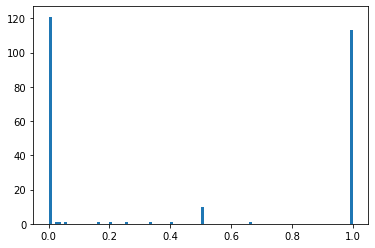

In [340]:
ious = [
    len(peptide_to_neg_tcr[pep] & peptide_to_tcr[pep]) / len(peptide_to_neg_tcr[pep] | peptide_to_tcr[pep])
    for pep in peptide_to_neg_tcr
]
_ = plt.hist(ious, bins=100)